# **CLASSIFICATION VND**

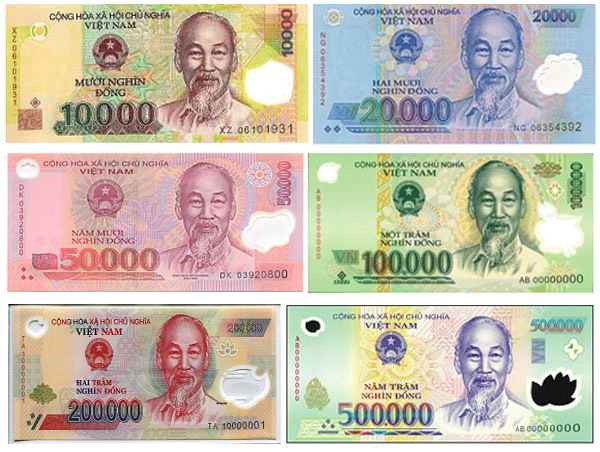

### Mount to GG Drive _ Import library

In [49]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
import zipfile
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from keras import Input, Model, Sequential, layers
from keras.layers import Dense, Flatten, InputLayer, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.image as mpimg
from numpy import random
from google.colab import files
from keras.preprocessing import image
import pathlib
from pathlib import Path

### Unzip dataset _ Visualizing

In [51]:
!unzip -q /content/gdrive/MyDrive/WP8/VND_Banknotes_dataset.zip -d /content/gdrive/MyDrive/WP8/VND_dataset_03_final

1000/Giấy_bạc_1000_đồng.jpg:  mismatching "local" filename (1000/Giс║еy_bс║бc_1000_─Сс╗Уng.jpg),
         continuing with "central" filename version
1000/Đồng_bạc_1000_đồng (1).jpeg:  mismatching "local" filename (1000/─Рс╗Уng_bс║бc_1000_─Сс╗Уng (1).jpeg),
         continuing with "central" filename version
1000/Đồng_bạc_1000_đồng.jpeg:  mismatching "local" filename (1000/─Рс╗Уng_bс║бc_1000_─Сс╗Уng.jpeg),
         continuing with "central" filename version
20000/Đồng_bạc_20.000.jpg:  mismatching "local" filename (20000/─Рс╗Уng_bс║бc_20.000.jpg),
         continuing with "central" filename version


In [52]:
data_dir = pathlib.Path('/content/gdrive/MyDrive/WP8/VND_dataset_03_final')

image_count = len(list(data_dir.glob("*/*")))
print(image_count)

1778


In [53]:
nrows = 9
ncols = 6
pic_index = 0 #

In [54]:
_1k_path = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/1000'
_2k_path = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/2000'
_5k_path = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/5000'
_10k_path = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/10000'
_20k_path = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/20000'
_50k_path = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/50000'
_100k_path = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/100000'
_200k_path = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/200000'
_500k_path = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/500000'


In [55]:
_1k_fnames = os.listdir(_1k_path)
_2k_fnames = os.listdir(_2k_path)
_5k_fnames = os.listdir(_5k_path)
_10k_fnames = os.listdir(_10k_path)
_20k_fnames = os.listdir(_20k_path)
_50k_fnames = os.listdir(_50k_path)
_100k_fnames = os.listdir(_100k_path)
_200k_fnames = os.listdir(_200k_path)
_500k_fnames = os.listdir(_500k_path)

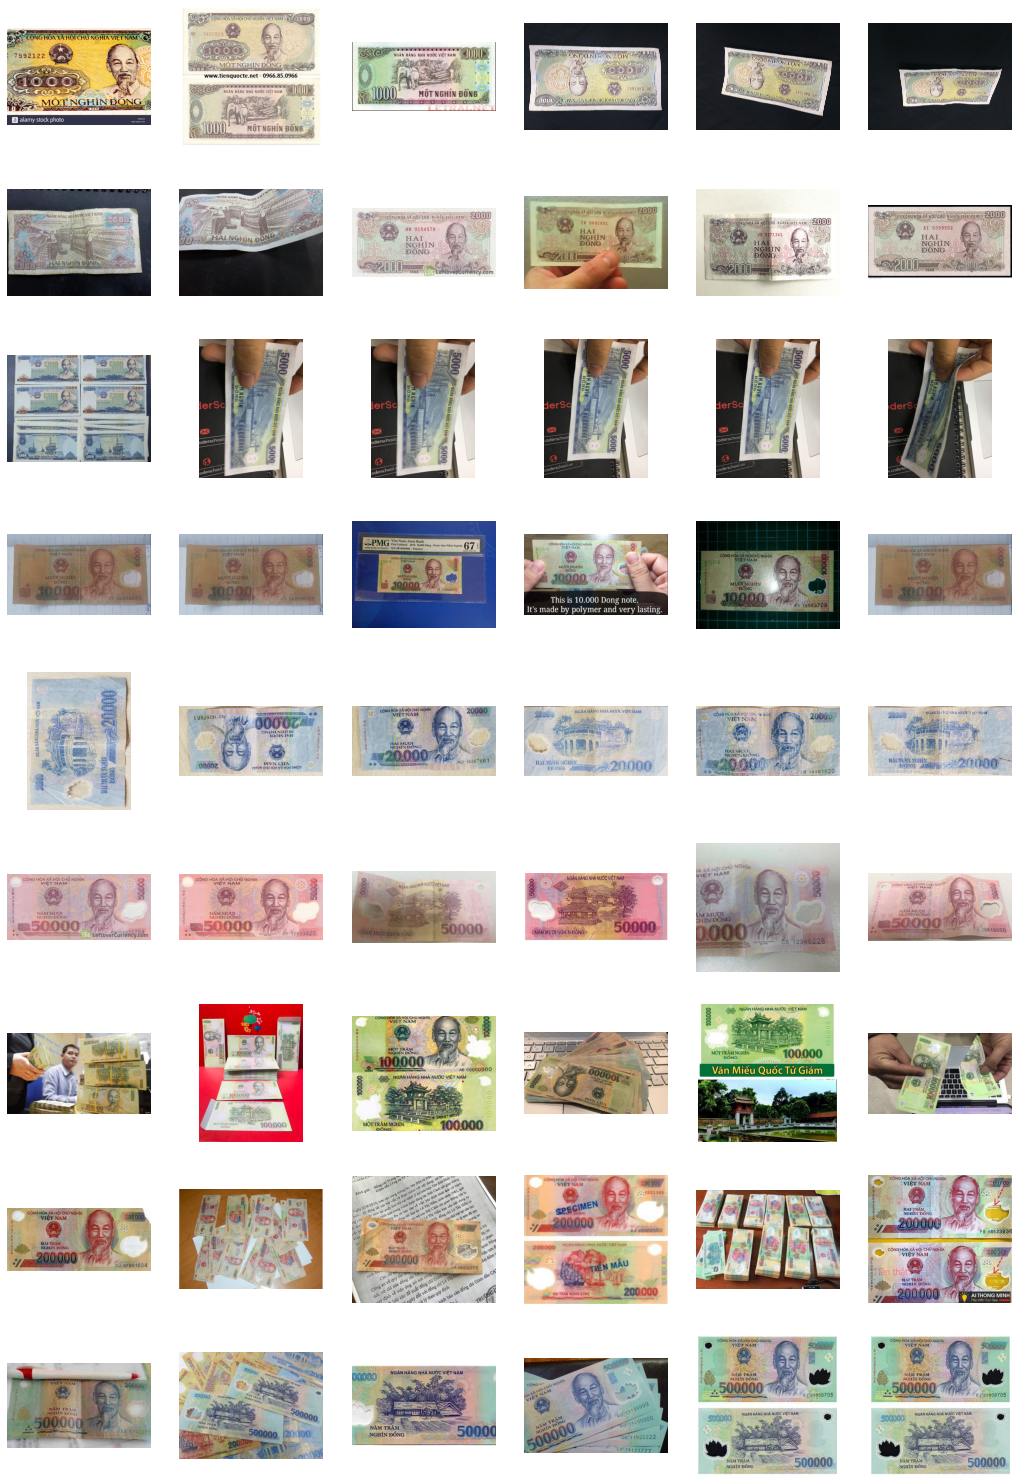

In [56]:
# Setup matplotlib figure, keep hitting shift + enter to go through 4 next images / class each time

def show_next_pics(data_path, data_fname):
  next_pics = [os.path.join(data_path, fname) for fname in data_fname[pic_index-6 : pic_index]]
  return next_pics
  
plt.figure().set_size_inches(ncols*3, nrows*3)
pic_index += 6

_1k_pic = show_next_pics(_1k_path, _1k_fnames)
_2k_pic = show_next_pics(_2k_path, _2k_fnames)
_5k_pic = show_next_pics(_5k_path, _5k_fnames)
_10k_pic = show_next_pics(_10k_path, _10k_fnames)
_20k_pic = show_next_pics(_20k_path, _20k_fnames)
_50k_pic = show_next_pics(_50k_path, _50k_fnames)
_100k_pic = show_next_pics(_100k_path, _100k_fnames)
_200k_pic = show_next_pics(_200k_path, _200k_fnames)
_500k_pic = show_next_pics(_500k_path, _500k_fnames)

for i, img_path in enumerate(_1k_pic + _2k_pic + _5k_pic + _10k_pic + _20k_pic + _50k_pic + _100k_pic + _200k_pic + _500k_pic):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


### Preparation

In [57]:
# Let's save your project results in Google Drive
PROJECT = pathlib.Path('/content/gdrive/MyDrive/WP8/VND_dataset_03_final')

RESULT      = PROJECT/'Results'
SAVED_MODEL = RESULT/'Saved_model'

IMG_SIZE = 224  # This is required by your pretrained-model
BATCH_SIZE = 32

In [58]:
# Create generator_augmentation_maker
def generator_augmentation_maker():
  train_gen = ImageDataGenerator(rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 brightness_range=[0.2,1.5],
                                 fill_mode='nearest',
                                 validation_split=0.2)     # IMPORTANT
  
  val_gen = ImageDataGenerator(validation_split=0.2)        # IMPORTANT

  train_generator = train_gen.flow_from_directory(data_dir,
                                                  target_size=(IMG_SIZE, IMG_SIZE),  
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=42,            # IMPORTANT
                                                  subset='training')  # IMPORTANT

  validation_generator = val_gen.flow_from_directory(data_dir,
                                                     target_size=(IMG_SIZE, IMG_SIZE),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='categorical',
                                                     shuffle=False,        # IMPORTANT
                                                     seed=42,              # IMPORTANT
                                                     subset='validation')  # IMPORTANT
  return train_generator, validation_generator

In [59]:
train_generator, validation_generator = generator_augmentation_maker()

Found 1406 images belonging to 9 classes.
Found 349 images belonging to 9 classes.


In [60]:
train_generator.class_indices

{'1000': 0,
 '10000': 1,
 '100000': 2,
 '2000': 3,
 '20000': 4,
 '200000': 5,
 '5000': 6,
 '50000': 7,
 '500000': 8}

### Build model

In [61]:
base_model = keras.applications.DenseNet201(weights='imagenet',
                                            input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False)

# Freeze the base model's weights
base_model.trainable=False 

In [62]:
from keras.applications.densenet import preprocess_input

def model_maker():
  # Preprocess_input
  inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = keras.applications.densenet.preprocess_input(inputs)

  # Connect to your base model
  x = base_model(x, training = False)

  # Add your own classifier
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.BatchNormalization()(x)
  outputs = keras.layers.Dense(9, activation='softmax')(x)
  model = keras.Model(inputs, outputs)
  return model

In [63]:
model = model_maker()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                           

In [64]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [65]:
init_epochs = 30

callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
            tf.keras.callbacks.ModelCheckpoint(filepath = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_save.h5',
                                                save_weights_only = False,
                                                save_best_only = True,
                                                verbose = 1)]

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = init_epochs,
                    callbacks = callbacks,
                    verbose = 1)

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 1.1109 - accuracy: 0.6607
Epoch 00001: val_loss improved from inf to 0.91131, saving model to /content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_save.h5
44/44 [==============================] - 206s 4s/step - loss: 1.1109 - accuracy: 0.6607 - val_loss: 0.9113 - val_accuracy: 0.7765
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 0.3543 - accuracy: 0.9118
Epoch 00002: val_loss improved from 0.91131 to 0.53417, saving model to /content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_save.h5
44/44 [==============================] - 152s 3s/step - loss: 0.3543 - accuracy: 0.9118 - val_loss: 0.5342 - val_accuracy: 0.8510
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.9395
Epoch 00003: val_loss improved from 0.53417 to 0.40546, saving model to /content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_save.h5
44/44 [==============================] - 154s 4s

In [66]:
model.evaluate(validation_generator)

11/11 [==============================] - 25s 2s/step - loss: 0.1922 - accuracy: 0.9542


[0.19219321012496948, 0.9541547298431396]

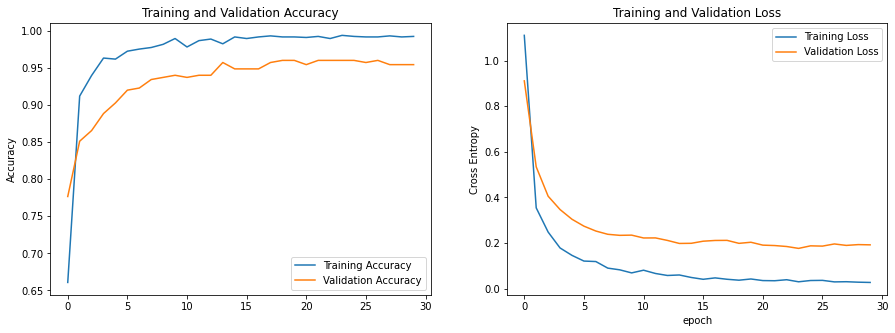

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model_No.1

In [68]:
model.save('/content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_save.h5')

In [ ]:
# Way 2:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(filepath="/content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_checkpoint.h5",
                                      save_weights_only=False, # the whole model (False) or only weights (True) 
                                      save_best_only=True, # keep the best model with lowest validation loss
                                      monitor='val_loss',
                                      verbose=1)

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=5,
                    callbacks=[checkpoint_callback],
                    verbose=2)

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
restored_model = tf.keras.models.load_model('/content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_save.h5')

# Show the model architecture
restored_model.summary()

# We need to define its optimizer and loss function again since the h5 file
# does not contain those information :(
restored_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Re-evaluate the model
loss, acc = restored_model.evaluate(validation_generator)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

### Test case_No.1

In [69]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
from google.colab import files

Saving bao-li-xi-bang-tien-500-ngan-dong-gay-sot-thi-truong-tet-2.jpeg to bao-li-xi-bang-tien-500-ngan-dong-gay-sot-thi-truong-tet-2.jpeg
bao-li-xi-bang-tien-500-ngan-dong-gay-sot-thi-truong-tet-2.jpeg


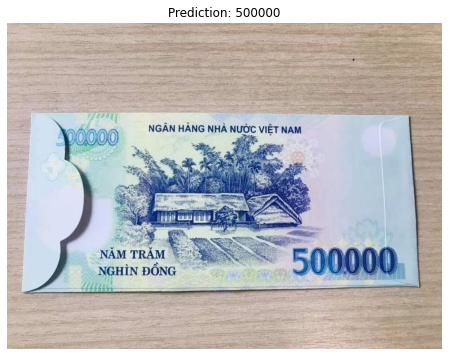

True

In [73]:
# Upload file
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  image_path = './' + fn

# Predict function
def predict(model, image_path, img_size):
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  prediction = model.predict(img)

  for key, value in validation_generator.class_indices.items():
    if value == prediction[0].argmax():
      pred = key

  plt.figure(figsize=(9, 6))
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.title('Prediction: ' + pred.upper())
  plt.grid(b=None)
  plt.axis('off')
  plt.show()

  return True

# Predict 
image_path = image_path
predict(model, image_path, IMG_SIZE)

### Model fine tunning

In [74]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  707


In [76]:
# Unfreeze the base_model.
base_model.trainable = True

# Fine-tune from layer 650
fine_tune_at = 700

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.00001), 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                           

In [79]:
init_epochs = 70
fine_tune_epochs = 20
total_epochs = init_epochs + fine_tune_epochs

# YOUR CALLBACKS
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10),
             tf.keras.callbacks.ModelCheckpoint(filepath = '/content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_save.h5',
                                                save_weights_only = False,
                                                save_best_only = True,
                                                verbose = 1)]

history_fine = model.fit(train_generator, 
                         validation_data = validation_generator,
                         epochs = total_epochs,
                         initial_epoch = init_epochs,
                         callbacks = callbacks)

Epoch 71/90
44/44 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9957
Epoch 00071: val_loss improved from inf to 0.18094, saving model to /content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_save.h5
44/44 [==============================] - 149s 3s/step - loss: 0.0183 - accuracy: 0.9957 - val_loss: 0.1809 - val_accuracy: 0.9570
Epoch 72/90
44/44 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9972
Epoch 00072: val_loss improved from 0.18094 to 0.18063, saving model to /content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_save.h5
44/44 [==============================] - 147s 3s/step - loss: 0.0162 - accuracy: 0.9972 - val_loss: 0.1806 - val_accuracy: 0.9570
Epoch 73/90
44/44 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9929
Epoch 00073: val_loss did not improve from 0.18063
44/44 [==============================] - 142s 3s/step - loss: 0.0235 - accuracy: 0.9929 - val_loss: 0.1816 - val_accuracy: 0.9570
Ep

In [80]:
model.evaluate(validation_generator)

11/11 [==============================] - 24s 2s/step - loss: 0.1807 - accuracy: 0.9542


[0.1806822568178177, 0.9541547298431396]

In [81]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

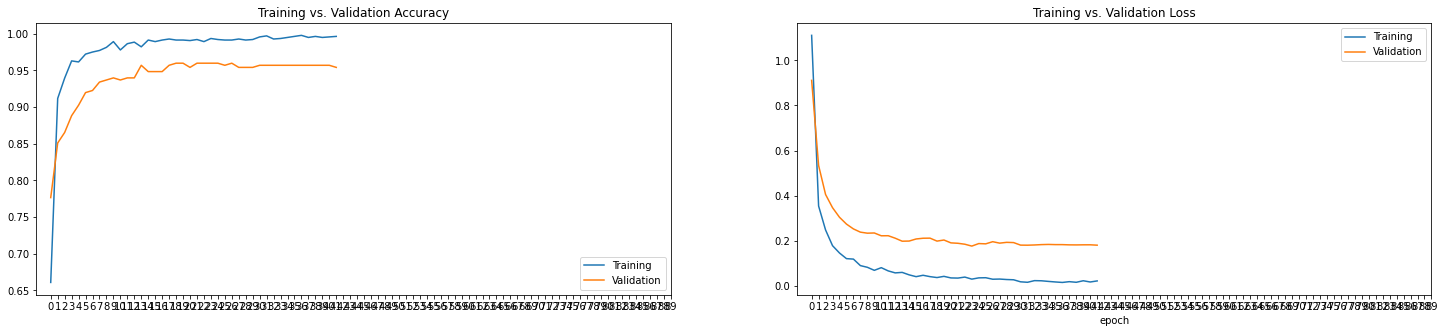

In [82]:
plt.figure(figsize=(25, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0.9, 1])
# plt.plot([init_epochs,init_epochs],
#           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
# plt.plot([init_epochs,init_epochs],
#          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training vs. Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model_No.2

In [95]:
model.save('/content/gdrive/MyDrive/WP8/VND_dataset_03_final/my_model_save.h5')

### Test case_No2

Saving Vietnamese-dong.jpeg to Vietnamese-dong.jpeg
Vietnamese-dong.jpeg


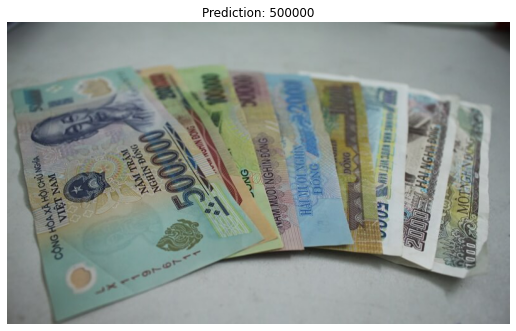

True

In [94]:
# Upload file
uploaded = files.upload()
for fn in uploaded.keys():
  print(fn)
  image_path = './' + fn

# Predict function
def predict(model, image_path, img_size):
  img = image.load_img(image_path, target_size=(img_size, img_size))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  prediction = model.predict(img)

  for key, value in validation_generator.class_indices.items():
    if value == prediction[0].argmax():
      pred = key

  plt.figure(figsize=(9, 6))
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.title('Prediction: ' + pred.upper())
  plt.grid(b=None)
  plt.axis('off')
  plt.show()

  return True

# Predict 
image_path = image_path
predict(model, image_path, IMG_SIZE)

### Error analysis